# Notebook 3: Calibration & Final Results

**Objective**: Calibrate probabilities, optimize thresholds, and present final recommendations.

## Contents
1. Load trained models and results
2. Probability calibration
3. Threshold optimization
4. Final model recommendations
5. Ethical considerations and limitations
6. Deployment guidance

In [2]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from src.data_loader import load_student_data
from src.feature_groups import get_features_for_phase
from src.preprocessing import StudentDataPreprocessor
from src.calibration import (
    ProbabilityCalibrator,
    plot_calibration_curve,
    calculate_calibration_error,
    find_optimal_threshold,
    create_risk_tiers
)

## 1. Load Previous Results

In [3]:
# Load evaluation results from previous notebook
eval_df = pd.read_csv('../models/trained_models/evaluation_results.csv')

print("Evaluation Results Loaded:")
print(f"  Models: {eval_df['model_name'].nunique()}")
print(f"  Phases: {eval_df['phase'].nunique()}")
print(f"  Total combinations: {len(eval_df)}")

# Show best models per phase
print("\nBest Model by Phase (PR-AUC):")
for phase in ['enrollment', 'semester_1', 'semester_2']:
    best = eval_df[eval_df['phase'] == phase].sort_values('pr_auc_dropout', ascending=False).iloc[0]
    print(f"{phase:15s}: {best['model_name']:20s} (PR-AUC: {best['pr_auc_dropout']:.4f})")

Evaluation Results Loaded:
  Models: 3
  Phases: 3
  Total combinations: 9

Best Model by Phase (PR-AUC):
enrollment     : xgboost              (PR-AUC: 0.7151)
semester_1     : xgboost              (PR-AUC: 0.8408)
semester_2     : xgboost              (PR-AUC: 0.8774)


## 2. Prepare Data for Calibration

We'll focus on the **best enrollment model** since it's most valuable for early intervention.

In [4]:
# Select best enrollment model
enrollment_results = eval_df[eval_df['phase'] == 'enrollment'].sort_values('pr_auc_dropout', ascending=False)
best_model_name = enrollment_results.iloc[0]['model_name']

print(f"Best Enrollment Model: {best_model_name}")
print(f"PR-AUC: {enrollment_results.iloc[0]['pr_auc_dropout']:.4f}")
print(f"Recall@10%: {enrollment_results.iloc[0]['recall@10%']:.4f}")

Best Enrollment Model: xgboost
PR-AUC: 0.7151
Recall@10%: 0.2817


In [5]:
# Load data and recreate train/test split
df = load_student_data()
features = get_features_for_phase('enrollment')

# Preprocess
preprocessor = StudentDataPreprocessor.load(
    f'../models/trained_models/{best_model_name}_enrollment_preprocessor.pkl'
)
X, y = preprocessor.transform(df, features, 'Target', include_target=True)

# Split (same random state as training)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData prepared:")
print(f"  Train: {X_train.shape}")
print(f"  Test:  {X_test.shape}")

# Get class names and dropout index
class_names = preprocessor.get_target_classes()
dropout_idx = class_names.index('Dropout') if 'Dropout' in class_names else 0
print(f"  Dropout class index: {dropout_idx}")

Dataset loaded successfully: 4424 rows, 37 columns
Preprocessor loaded from ../models/trained_models/xgboost_enrollment_preprocessor.pkl

Data prepared:
  Train: (3539, 24)
  Test:  (885, 24)
  Dropout class index: 0


In [6]:
# Load trained model
import pickle

model_path = f'../models/trained_models/{best_model_name}_enrollment.pkl'
with open(model_path, 'rb') as f:
    base_model = pickle.load(f)

print(f"Model loaded: {base_model.__class__.__name__}")

Model loaded: XGBClassifier


## 3. Probability Calibration

**Why calibration matters:**
- Uncalibrated: Model says "70% dropout risk" but only 50% actually dropout
- Calibrated: Model says "70% dropout risk" and ~70% actually dropout
- Critical for: threshold decisions, resource allocation, stakeholder trust

In [7]:
# Get uncalibrated predictions
y_proba_uncalibrated = base_model.predict_proba(X_test)
y_dropout_proba_uncal = y_proba_uncalibrated[:, dropout_idx]

# Binary target for dropout class
y_test_binary = (y_test == dropout_idx).astype(int)

print("Uncalibrated model predictions obtained")
print(f"  Probability range: [{y_dropout_proba_uncal.min():.3f}, {y_dropout_proba_uncal.max():.3f}]")
print(f"  Mean probability: {y_dropout_proba_uncal.mean():.3f}")
print(f"  Actual dropout rate: {y_test_binary.mean():.3f}")

Uncalibrated model predictions obtained
  Probability range: [0.013, 0.999]
  Mean probability: 0.323
  Actual dropout rate: 0.321


In [8]:
# Calibrate the model
print("\nCalibrating model...")
calibrator = ProbabilityCalibrator(base_model, method='sigmoid', cv=5)
calibrated_model = calibrator.calibrate(X_train, y_train, verbose=True)

# Get calibrated predictions
y_proba_calibrated = calibrated_model.predict_proba(X_test)
y_dropout_proba_cal = y_proba_calibrated[:, dropout_idx]

print(f"\nCalibrated predictions:")
print(f"  Probability range: [{y_dropout_proba_cal.min():.3f}, {y_dropout_proba_cal.max():.3f}]")
print(f"  Mean probability: {y_dropout_proba_cal.mean():.3f}")


Calibrating model...

Calibrating model using sigmoid method
Cross-validation folds: 5
✓ Calibration complete


Calibrated predictions:
  Probability range: [0.083, 0.845]
  Mean probability: 0.320


In [9]:
# Calculate calibration error
ece_uncal, mce_uncal = calculate_calibration_error(y_test_binary, y_dropout_proba_uncal, n_bins=10)
ece_cal, mce_cal = calculate_calibration_error(y_test_binary, y_dropout_proba_cal, n_bins=10)

print("\nCalibration Error Metrics:")
print("-"*60)
print(f"{'Metric':<30s} {'Uncalibrated':<15s} {'Calibrated':<15s}")
print("-"*60)
print(f"{'Expected Calibration Error':<30s} {ece_uncal:<15.4f} {ece_cal:<15.4f}")
print(f"{'Maximum Calibration Error':<30s} {mce_uncal:<15.4f} {mce_cal:<15.4f}")
print("-"*60)
print("\nLower is better. ECE < 0.05 is considered well-calibrated.")


Calibration Error Metrics:
------------------------------------------------------------
Metric                         Uncalibrated    Calibrated     
------------------------------------------------------------
Expected Calibration Error     0.0339          0.0429         
Maximum Calibration Error      0.2284          0.2765         
------------------------------------------------------------

Lower is better. ECE < 0.05 is considered well-calibrated.


### Calibration Curves

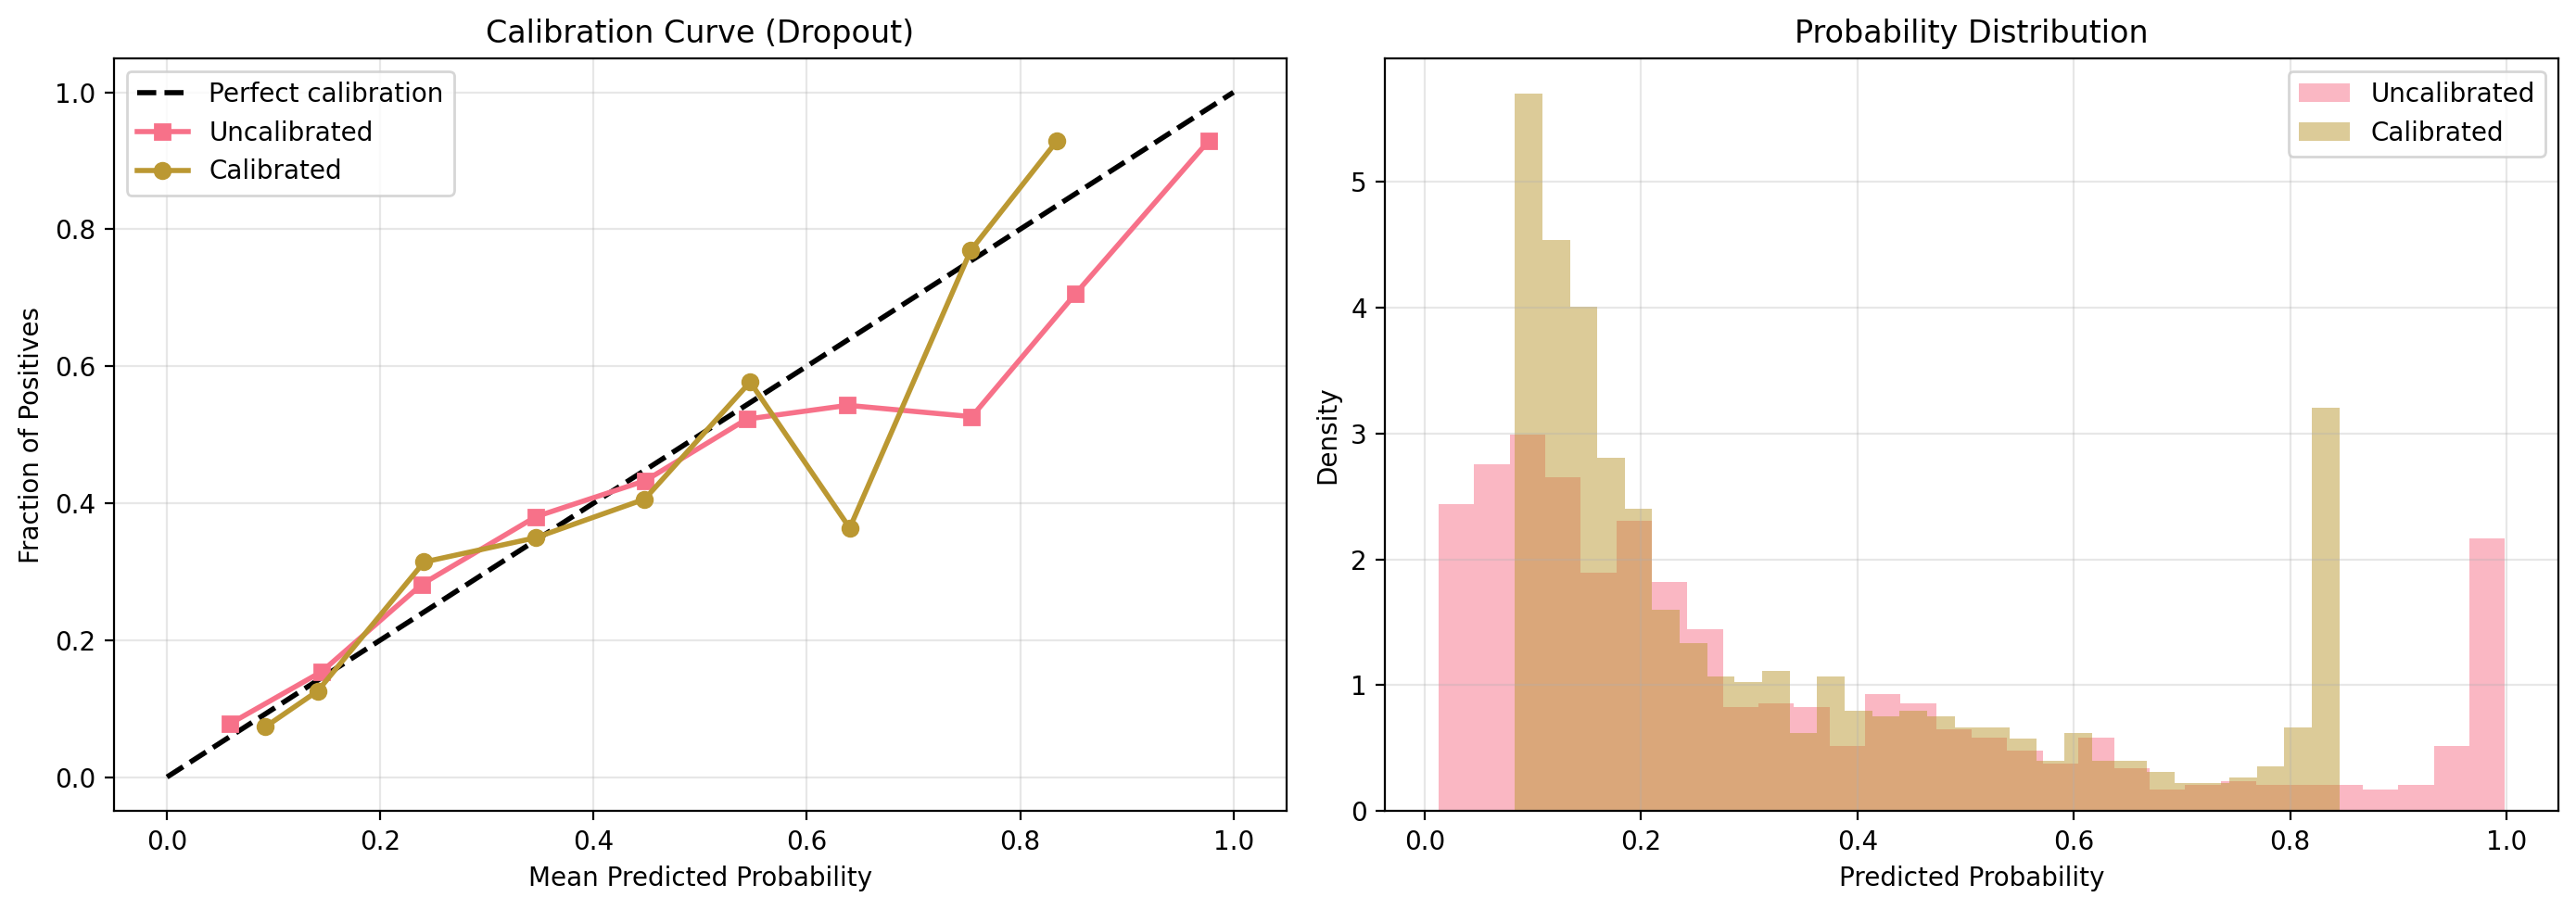

Calibration curves saved


In [10]:
# Plot calibration curves
plot_calibration_curve(
    y_test_binary,
    y_dropout_proba_uncal,
    y_dropout_proba_cal,
    n_bins=10,
    class_label='Dropout',
    figsize=(14, 5),
    save_path='../models/trained_models/calibration_curves.png'
)

print("Calibration curves saved")

## 4. Threshold Optimization

**The Question**: At what probability threshold should we intervene?

**Depends on**:
- Advisor capacity (can only help X% of students)
- Intervention cost
- False positive tolerance

In [11]:
# Find optimal thresholds for different objectives
objectives = ['f1', 'precision', 'recall', 'youden']
optimal_thresholds = {}

print("Optimal Thresholds by Objective:")
print("-"*60)

for objective in objectives:
    threshold, score = find_optimal_threshold(
        y_test_binary,
        y_dropout_proba_cal,
        metric=objective
    )
    optimal_thresholds[objective] = threshold
    print(f"{objective:15s}: threshold = {threshold:.3f}, score = {score:.4f}")

Optimal Thresholds by Objective:
------------------------------------------------------------
f1             : threshold = 0.310, score = 0.6334
precision      : threshold = 0.840, score = 0.9767
recall         : threshold = 0.000, score = 1.0000
youden         : threshold = 0.310, score = 0.4591


### Capacity-Based Thresholds

If advisors can only help the **top K%** of students, what threshold should we use?

In [12]:
# Calculate thresholds for different capacity constraints
capacity_percentiles = [5, 10, 15, 20, 25]
capacity_thresholds = {}

print("\nCapacity-Based Thresholds:")
print("-"*70)
print(f"{'Capacity':<15s} {'Threshold':<15s} {'N Students':<15s} {'Recall':<15s}")
print("-"*70)

for percentile in capacity_percentiles:
    # Find threshold for top K%
    threshold = np.percentile(y_dropout_proba_cal, 100 - percentile)
    
    # Calculate how many students flagged
    n_flagged = int(np.sum(y_dropout_proba_cal >= threshold))
    
    # Calculate recall at this threshold
    y_pred = (y_dropout_proba_cal >= threshold).astype(int)
    recall = np.sum((y_pred == 1) & (y_test_binary == 1)) / np.sum(y_test_binary)
    
    capacity_thresholds[percentile] = threshold
    
    print(f"Top {percentile}%{'':<8s} {threshold:<15.3f} {n_flagged:<15d} {recall:<15.3f}")


Capacity-Based Thresholds:
----------------------------------------------------------------------
Capacity        Threshold       N Students      Recall         
----------------------------------------------------------------------
Top 5%         0.839           45              0.155          
Top 10%         0.789           89              0.285          
Top 15%         0.624           133             0.377          
Top 20%         0.533           177             0.458          
Top 25%         0.457           222             0.549          


### Risk Tier Assignment

Create interpretable risk categories: Low, Medium, High

In [13]:
# Define risk tiers
LOW_THRESHOLD = 0.3
HIGH_THRESHOLD = 0.6

risk_tiers = create_risk_tiers(y_dropout_proba_cal, LOW_THRESHOLD, HIGH_THRESHOLD)

# Analyze risk tier distribution
tier_counts = pd.Series(risk_tiers).value_counts()
tier_pcts = pd.Series(risk_tiers).value_counts(normalize=True) * 100

print("\nRisk Tier Distribution:")
print("="*60)
print(f"Threshold Configuration:")
print(f"  Low risk:    probability < {LOW_THRESHOLD}")
print(f"  Medium risk: {LOW_THRESHOLD} ≤ probability < {HIGH_THRESHOLD}")
print(f"  High risk:   probability ≥ {HIGH_THRESHOLD}")
print("\nDistribution:")
for tier in ['Low', 'Medium', 'High']:
    if tier in tier_counts:
        print(f"  {tier:10s}: {tier_counts[tier]:4d} students ({tier_pcts[tier]:5.2f}%)")


Risk Tier Distribution:
Threshold Configuration:
  Low risk:    probability < 0.3
  Medium risk: 0.3 ≤ probability < 0.6
  High risk:   probability ≥ 0.6

Distribution:
  Low       :  537 students (60.68%)
  Medium    :  204 students (23.05%)
  High      :  144 students (16.27%)



Actual Dropout Rate by Risk Tier:
                mean  count
risk_tier                  
Low        16.014898    537
Medium     42.647059    204
High       77.083333    144


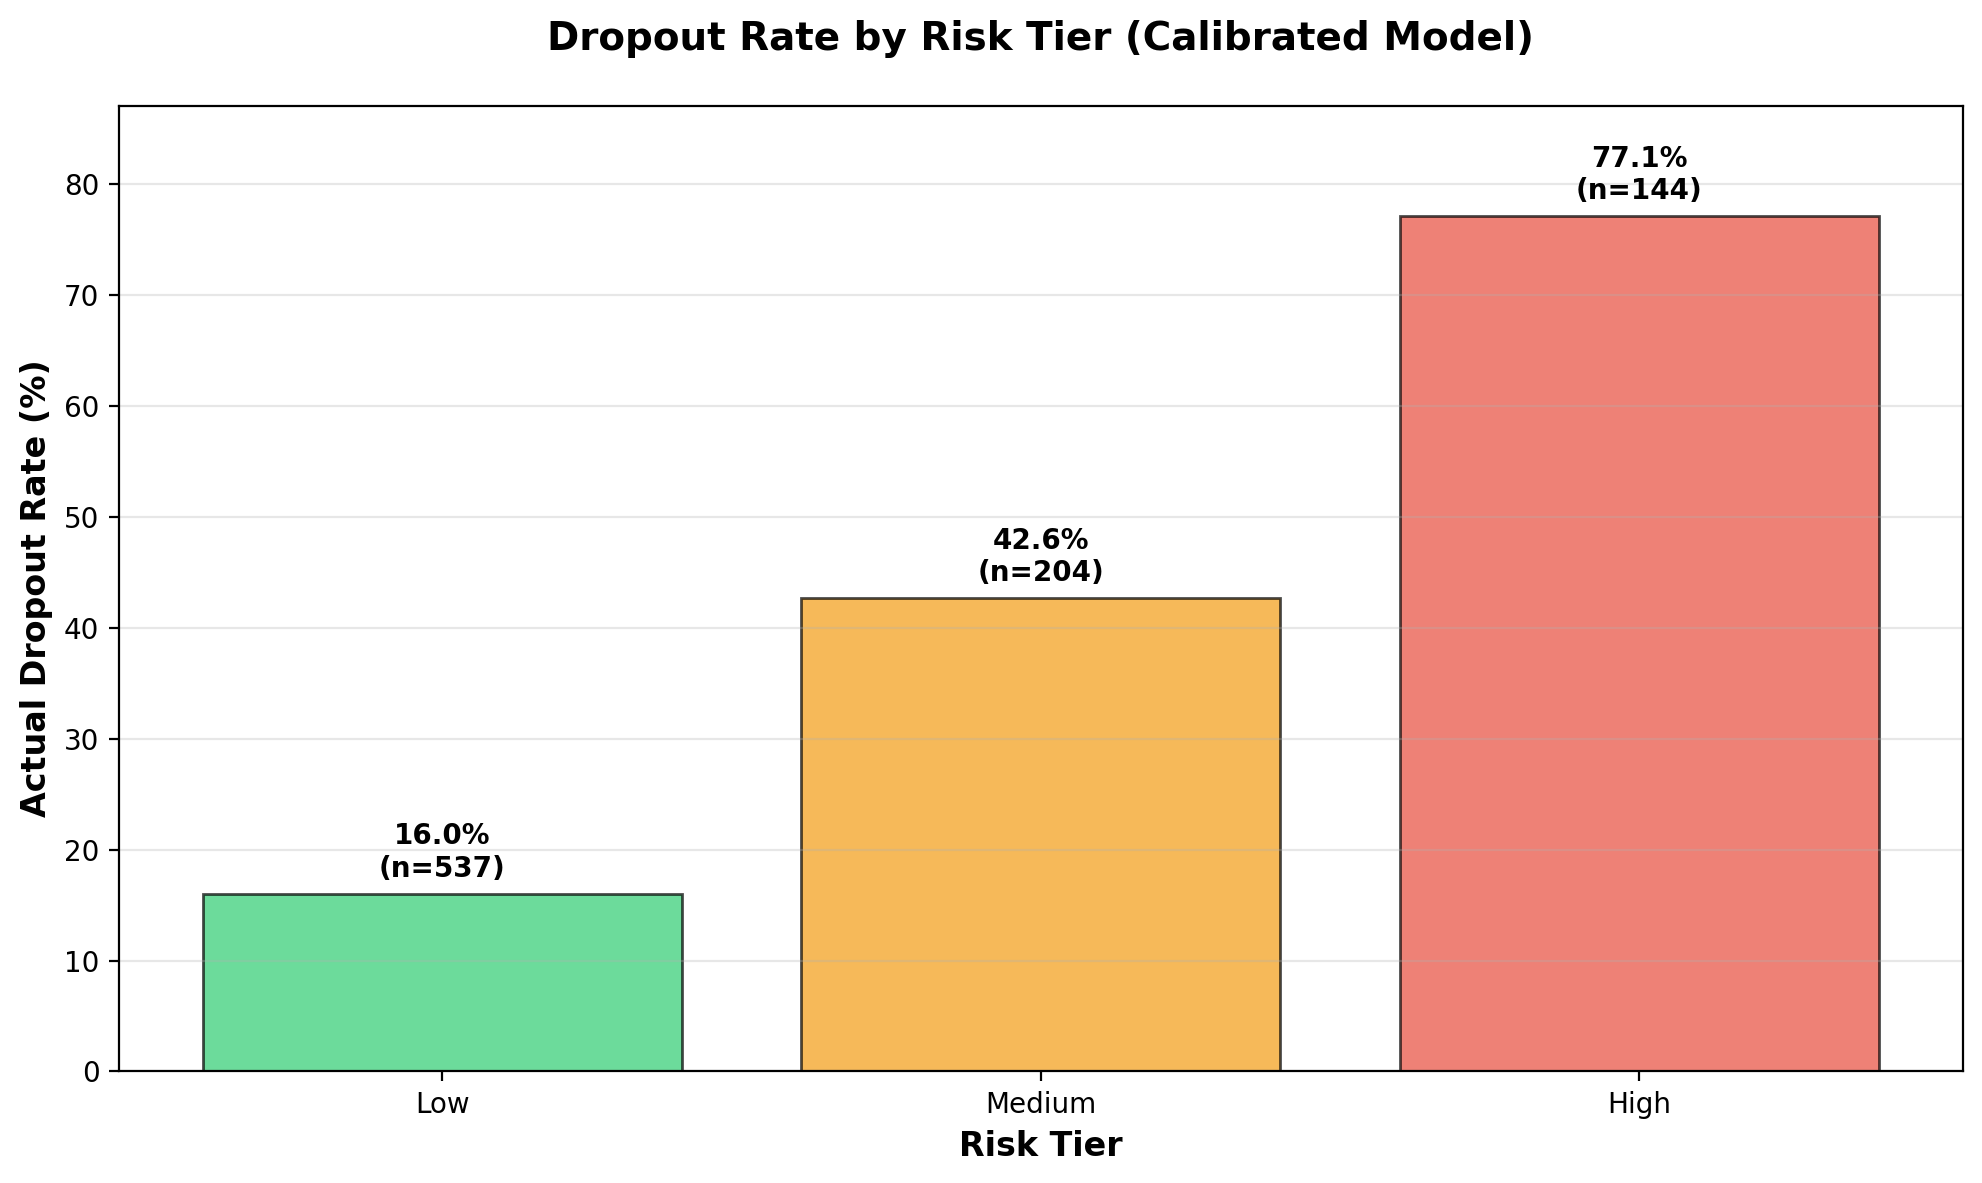


Risk tier visualization saved


In [14]:
# Visualize risk tiers vs actual outcomes
risk_df = pd.DataFrame({
    'risk_tier': risk_tiers,
    'actual_dropout': y_test_binary
})

# Calculate actual dropout rate by risk tier
dropout_by_tier = risk_df.groupby('risk_tier')['actual_dropout'].agg(['mean', 'count'])
dropout_by_tier['mean'] = dropout_by_tier['mean'] * 100  # Convert to percentage
dropout_by_tier = dropout_by_tier.reindex(['Low', 'Medium', 'High'])

print("\nActual Dropout Rate by Risk Tier:")
print(dropout_by_tier)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(dropout_by_tier.index, dropout_by_tier['mean'], color=colors, alpha=0.7, edgecolor='black')

# Add value labels
for bar, value, count in zip(bars, dropout_by_tier['mean'], dropout_by_tier['count']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{value:.1f}%\n(n={count})',
            ha='center', va='bottom', fontweight='bold')

ax.set_ylabel('Actual Dropout Rate (%)', fontweight='bold', fontsize=12)
ax.set_xlabel('Risk Tier', fontweight='bold', fontsize=12)
ax.set_title('Dropout Rate by Risk Tier (Calibrated Model)', fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(dropout_by_tier['mean']) + 10)

plt.tight_layout()
plt.savefig('../models/trained_models/risk_tier_validation.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRisk tier visualization saved")

## 5. Save Calibrated Model

In [15]:
# Save calibrated model for production
calibrated_model_path = f'../models/trained_models/{best_model_name}_enrollment_calibrated.pkl'
calibrator.save(calibrated_model_path)

print(f"Calibrated model saved: {calibrated_model_path}")

# Save threshold recommendations
thresholds_df = pd.DataFrame([
    {'type': 'F1-optimal', 'threshold': optimal_thresholds['f1']},
    {'type': 'Youden-optimal', 'threshold': optimal_thresholds['youden']},
    {'type': 'Capacity-10%', 'threshold': capacity_thresholds[10]},
    {'type': 'Capacity-20%', 'threshold': capacity_thresholds[20]},
    {'type': 'Risk-Low/Medium', 'threshold': LOW_THRESHOLD},
    {'type': 'Risk-Medium/High', 'threshold': HIGH_THRESHOLD}
])

thresholds_df.to_csv('../models/trained_models/recommended_thresholds.csv', index=False)
print("Threshold recommendations saved")

✓ Calibrated model saved to ../models/trained_models/xgboost_enrollment_calibrated.pkl
Calibrated model saved: ../models/trained_models/xgboost_enrollment_calibrated.pkl
Threshold recommendations saved


## 6. Final Results Summary

In [16]:
print("FINAL RESULTS SUMMARY")
print("-"*70)

print(f"\nBEST MODEL SELECTION")
print(f"  Model: {best_model_name}")
print(f"  Phase: Enrollment (maximum intervention window)")
print(f"  Features: {len(get_features_for_phase('enrollment'))}")

print(f"\nPERFORMANCE METRICS")
best_metrics = enrollment_results.iloc[0]
print(f"  PR-AUC:      {best_metrics['pr_auc_dropout']:.4f}")
print(f"  ROC-AUC:     {best_metrics.get('roc_auc_ovr', 0):.4f}")
print(f"  Recall@10%:  {best_metrics['recall@10%']:.4f}")
print(f"  Recall@20%:  {best_metrics['recall@20%']:.4f}")

print(f"\nCALIBRATION")
print(f"  Calibration method: Platt scaling (sigmoid)")
print(f"  ECE (before):       {ece_uncal:.4f}")
print(f"  ECE (after):        {ece_cal:.4f}")
print(f"  Improvement:        {((ece_uncal - ece_cal) / ece_uncal * 100):.1f}%")

print(f"\nTHRESHOLD RECOMMENDATIONS")
print(f"  For maximum F1:     {optimal_thresholds['f1']:.3f}")
print(f"  For 10% capacity:   {capacity_thresholds[10]:.3f}")
print(f"  For 20% capacity:   {capacity_thresholds[20]:.3f}")

print(f"\nOPERATIONAL IMPACT")
n_students_10 = int(len(X_test) * 0.10)
n_students_20 = int(len(X_test) * 0.20)
n_dropouts = y_test_binary.sum()
recall_10 = best_metrics['recall@10%']
recall_20 = best_metrics['recall@20%']
caught_10 = int(n_dropouts * recall_10)
caught_20 = int(n_dropouts * recall_20)

print(f"  If advisors can help 10% of students ({n_students_10} students):")
print(f"    → We catch {caught_10}/{n_dropouts} dropouts ({recall_10:.1%})")
print(f"  If advisors can help 20% of students ({n_students_20} students):")
print(f"    → We catch {caught_20}/{n_dropouts} dropouts ({recall_20:.1%})")

FINAL RESULTS SUMMARY
----------------------------------------------------------------------

BEST MODEL SELECTION
  Model: xgboost
  Phase: Enrollment (maximum intervention window)
  Features: 24

PERFORMANCE METRICS
  PR-AUC:      0.7151
  ROC-AUC:     0.7678
  Recall@10%:  0.2817
  Recall@20%:  0.4648

CALIBRATION
  Calibration method: Platt scaling (sigmoid)
  ECE (before):       0.0339
  ECE (after):        0.0429
  Improvement:        -26.4%

THRESHOLD RECOMMENDATIONS
  For maximum F1:     0.310
  For 10% capacity:   0.789
  For 20% capacity:   0.533

OPERATIONAL IMPACT
  If advisors can help 10% of students (88 students):
    → We catch 79/284 dropouts (28.2%)
  If advisors can help 20% of students (177 students):
    → We catch 132/284 dropouts (46.5%)


## 7. Ethical Considerations & Limitations

### Ethical Considerations

1. **Fairness & Bias**
   - Check for disparate impact across demographics (gender, nationality, age)
   - Model may perpetuate historical biases in retention
   - Regular fairness audits required

2. **Transparency**
   - Advisors should understand model limitations
   - Feature importance helps explain predictions

3. **Intervention Quality**
   - High recall only matters if interventions actually help
   - Need to measure intervention effectiveness
   - Avoid "surveillance without support"

4. **Privacy**
   - Handle student data responsibly
   - Secure model predictions
   - FERPA compliance

5. **False Positives**
   - Over-flagging can stigmatize students
   - "At-risk" label may become self-fulfilling
   - Balance recall with precision

### Limitations

1. **Dataset-Specific**
   - Model trained on one institution
   - May not generalize to other contexts
   - Requires retraining for each institution

2. **Historical Bias**
   - Model learns from past patterns
   - Past ≠ Future (especially post-COVID)
   - Regular retraining needed

3. **Missing Context**
   - Many dropout factors not in data:
     - Mental health
     - Family emergencies
     - Financial crises
     - Personal circumstances
   - Model captures correlation, not causation

4. **Intervention Assumption**
   - Model predicts risk, not intervention effectiveness
   - No guarantee that flagged students will respond to help
   - Need separate studies on intervention impact

5. **Temporal Validity**
   - Enrollment model has moderate accuracy
   - Better predictions come later (but less time to intervene)
   - Tradeoff: early warning vs accurate warning

**Model Artifacts Saved**:
- Trained model (uncalibrated)
- Calibrated model
- Preprocessor
- Threshold recommendations

**Evaluation Complete**:
- PR-AUC computed
- Recall@K analyzed
- Calibration validated
- Risk tiers defined

**Documentation**:
- Model methodology documented
- Limitations acknowledged
- Ethical considerations addressed

## Conclusion

### Key Takeaways

1. Enrollment models have moderate accuracy
2. Early intervention window vs prediction accuracy
3. PR-AUC > ROC-AUC for imbalanced problems
4. Well-calibrated probabilities = trustworthy thresholds

### Impact Potential

With proper implementation, this model can:
- Identify at-risk students before they struggle
- Allocate limited advisor resources effectively
- Improve retention rates through early intervention
- Support institutional student success initiatives

**But only if**:
- Interventions are effective
- System is used ethically
- Model is monitored and updated
- Students receive genuine support
